# Multi-class Classification

In [1]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [2]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 113MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 126MB/s] 


In [3]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [4]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

 ## Parsing the dataset

In [5]:
def parse_data_from_input(filename):
 
  with open(filename) as file:
    csv_reader = csv.reader(file, delimiter=',')
    
    labels = []
    images = []
    for i,row in enumerate(csv_reader):
      if i > 0:
        labels.append(row[0])
        images.append(row[1:])
    images = np.array(images, dtype=np.float64)
    labels = np.array(labels, dtype=np.float64)

    images = images.reshape(images.shape[0], 28, 28)

    return images, labels

In [6]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays

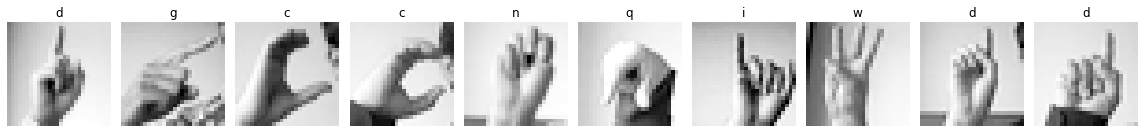

In [7]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

In [10]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  train_datagen = ImageDataGenerator(rescale= 1.0/255)

  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  validation_datagen = ImageDataGenerator(rescale=1.0/255)

  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 
  return train_generator, validation_generator

In [11]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN

In [23]:
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from keras.models import Sequential

def create_model():
  model = Sequential()
  model.add(Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
  model.add(MaxPooling2D(2,2))
  model.add(Conv2D(32,(3,3),activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(128,activation='relu'))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(26,activation='softmax'))
  

  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [24]:
#save the model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 6s 7ms/step - loss: 2.5046 - accuracy: 0.2660 - val_loss: 1.7851 - val_accuracy: 0.4360
Epoch 2/15
858/858 [==============================] - 6s 6ms/step - loss: 1.2452 - accuracy: 0.6075 - val_loss: 1.1434 - val_accuracy: 0.6308
Epoch 3/15
858/858 [==============================] - 6s 7ms/step - loss: 0.7720 - accuracy: 0.7507 - val_loss: 0.9081 - val_accuracy: 0.6843
Epoch 4/15
858/858 [==============================] - 6s 7ms/step - loss: 0.4973 - accuracy: 0.8459 - val_loss: 0.6658 - val_accuracy: 0.7872
Epoch 5/15
858/858 [==============================] - 6s 7ms/step - loss: 0.3100 - accuracy: 0.9104 - val_loss: 0.5900 - val_accuracy: 0.7956
Epoch 6/15
858/858 [==============================] - 5s 6ms/step - loss: 0.1775 - accuracy: 0.9528 - val_loss: 0.4649 - val_accuracy: 0.8424
Epoch 7/15
858/858 [==============================] - 5s 6ms/step - loss: 0.0919 - accuracy: 0.9793 - val_loss: 0.4221 - val_accuracy: 0.8763
Epoch 

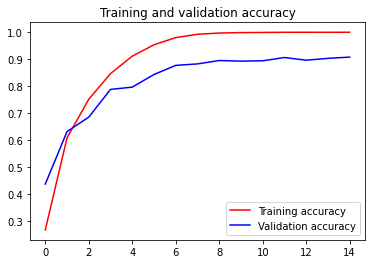

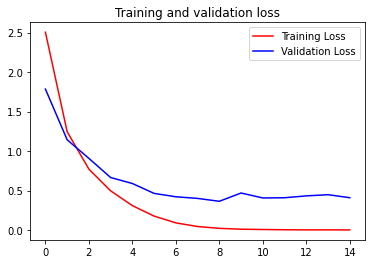

In [25]:
# Plot chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()